In [2]:
import qiskit
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit
import qiskit_aer 
from qiskit.quantum_info import state_fidelity
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit.quantum_info.states.random import random_statevector
from qiskit.circuit.library import Initialize
from qiskit.visualization import plot_bloch_multivector
import numpy as np
import matplotlib.pyplot as plt

from qiskit_aer.primitives import SamplerV2 as Sampler
from qiskit_aer.primitives import Estimator
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info import Operator

In [3]:
import math as m
import cmath as cm

def fsim(theta,phi,beta):
    fsim = Operator([[1,0,0,0],
                   [0,m.cos(theta),1j*cm.exp(1j*beta)*m.sin(theta),0],
                   [0,1j*cm.exp(-1j*beta)*m.sin(theta),m.cos(theta),0],
                   [0,0,0,cm.exp(1j*phi)]])
    return fsim

def add_fsim_half(qc,angles):
    theta = angles


    fsim1 = fsim(theta,0,0)
    fsim2 = fsim(2*theta,0,0)
    #Adding fsim in even layers
    for i in range(0,qc.num_qubits//2-1,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(\theta,\phi)$')

    for i in range(qc.num_qubits//2+1,qc.num_qubits-1,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(\theta,\phi)$')
        
    #Adding fsim in odd layers
    for i in range(1,qc.num_qubits//2-1,2):
        qc.unitary(fsim2,[i,i+1],label = r'fsim$(2\theta,\phi)$')

    for i in range(qc.num_qubits//2+2,qc.num_qubits-1,2):
        qc.unitary(fsim2,[i,i+1],label = r'fsim$(2\theta,\phi)$')

def add_fsim_inv_half(qc,angles):
    theta = angles


    fsim1 = fsim(theta,0,0)

        
    #Adding fsim in even layers
    for i in range(0,qc.num_qubits//2-1,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(\theta,\phi)$')

    for i in range(qc.num_qubits//2+1,qc.num_qubits-1,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(\theta,\phi)$')

In [4]:
N = 2
num_qubits = 2*N + 1

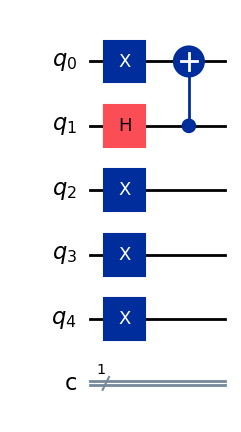

In [20]:
def state_circuit(N,num_cl_bits = 0):
    qc = QuantumCircuit(num_qubits,num_cl_bits)
    qc.x([0,2,3,4])
    qc.h(1)
    qc.cx(1,0)
    #qc.save_statevector()

    return qc

qc_test = state_circuit(N,1)
qc_test.draw('mpl')



In [19]:
sim = AerSimulator()
result = sim.run(qc_test).result()


state = result.get_statevector()
state.draw(output = 'latex')

<IPython.core.display.Latex object>

In [11]:
test_trotter_steps = 2
angles = np.pi/4

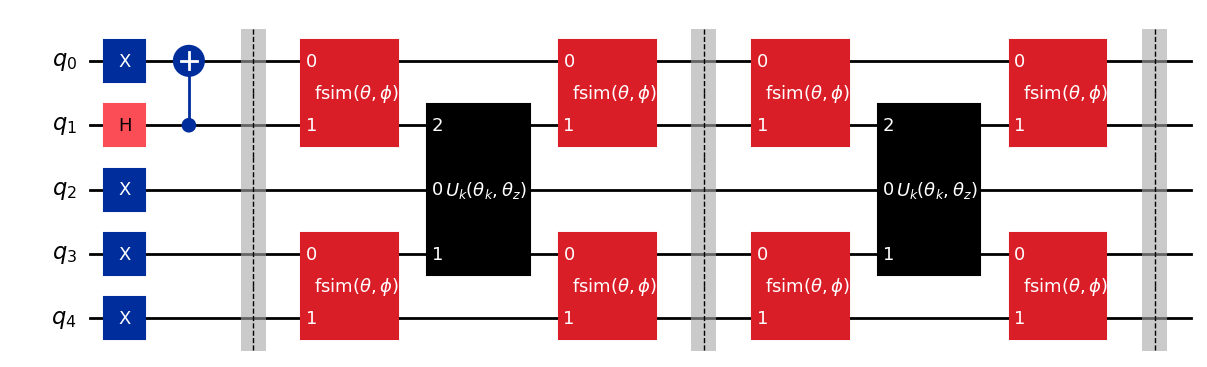

In [21]:
def kondo_unitary(theta_k,theta_z):

    l1 = cm.exp(1j*theta_z/2)
    l2 = cm.exp(-1j*theta_z/2)
    c1 = m.cos(theta_k)
    s1 = m.sin(theta_k)

    a = m.cos(np.sqrt(2)*theta_k) - (1j/np.sqrt(2))*m.sin(np.sqrt(2)*theta_k)
    a_dag = m.cos(np.sqrt(2)*theta_k) + (1j/np.sqrt(2))*m.sin(np.sqrt(2)*theta_k)
    b = (-1j/np.sqrt(2))*m.sin(np.sqrt(2)*theta_k)
    c = cm.exp(-1j*theta_k) 
    d = cm.exp(1j*theta_k)

    """kondo_unitary = Operator([[1,0,0,0,0,0,0,0],
                          [0,1,0,0,0,0,0,0],
                          [0,0,l1,0,0,0,0,0],
                          [0,0,0,c1*l2,1j*l2*s1,0,0,0],
                          [0,0,0,1j*l2*s1,c1*l2,0,0,0],
                          [0,0,0,0,0,l1,0,0],
                          [0,0,0,0,0,0,1,0],
                          [0,0,0,0,0,0,0,1]])"""
    kondo_unitary = Operator([[1,0,0,0,0,0,0,0],
                          [0,a,0,0,0,0,b,0],
                          [0,0,1,0,0,0,0,0],
                          [0,0,0,d,0,0,0,0],
                          [0,0,0,0,c,0,0,0],
                          [0,0,0,0,0,1,0,0],
                          [0,b,0,0,0,0,a_dag,0],
                          [0,0,0,0,0,0,0,1]])
    
    kondo_unitary_2 = Operator([[1,0,0,0,0,0,0,0],
                          [0,1,0,0,0,0,0,0],
                          [0,0,c1*l1,0,0,1j*s1*l1,0,0],
                          [0,0,0,l2,0,0,0,0],
                          [0,0,0,0,l2,0,0,0],
                          [0,0,1j*s1*l1,0,0,c1*l1,0,0],
                          [0,0,0,0,0,0,1,0],
                          [0,0,0,0,0,0,0,1]])
    
    return kondo_unitary_2

def circuit_3(N, trotter_steps,angles = 0,theta_k = 0,theta_z = 0, num_cl_bits = 0, trotter_barriers = False, save = False):
    if num_cl_bits == 0:
        qc = state_circuit(N)
    else:
        qc = state_circuit(N,num_cl_bits)
    #qc.x(N)
    qc.barrier()
    
    c = num_qubits//2
    for i in range(trotter_steps):
        add_fsim_half(qc,angles)
        qc.unitary(kondo_unitary(theta_k,theta_z),[c,c+1,c-1],label=r'$U_{k}(\theta_k,\theta_z)$')
        add_fsim_inv_half(qc,angles)
        if trotter_barriers:
            qc.barrier()
    if save == True:
        qc.save_statevector()
    #qc.save_statevector()  remove save for changing to operator
    return qc

qc = circuit_3(N,test_trotter_steps,angles,trotter_barriers = True)


gate_colours = {
    "displaycolor": {
        r'fsim$(2\theta,\phi)$': [ # gate name
            "#800080", # box color (red)
            "#FFFFFF" # box text color (white)
        ],

        r'fsim$(\theta,\phi)$': [ # gate name
            "#da1e28", # box color (red)
            "#FFFFFF" # box text color (white)
        ],

        r'$U_{k}(\theta_k,\theta_z)$': [ # gate name
            "#000000", # box color (red)
            "#FFFFFF" # box text color (white)
        ],
    },
}
qc.draw(output = 'mpl',style = gate_colours)

In [66]:
max_trotter_steps = 50
theta = np.pi/10
theta_k = np.pi/20
theta_z = -theta_k
measured_bits = list(range(2*N+1))

qc_list = []

for t in range(max_trotter_steps):
    qc = circuit_3(N, t, theta,theta_k,theta_z,num_cl_bits = len(measured_bits), trotter_barriers = True, save = True)
    qc.measure(measured_bits,list(range(len(measured_bits))))
    qc_list.append(qc)


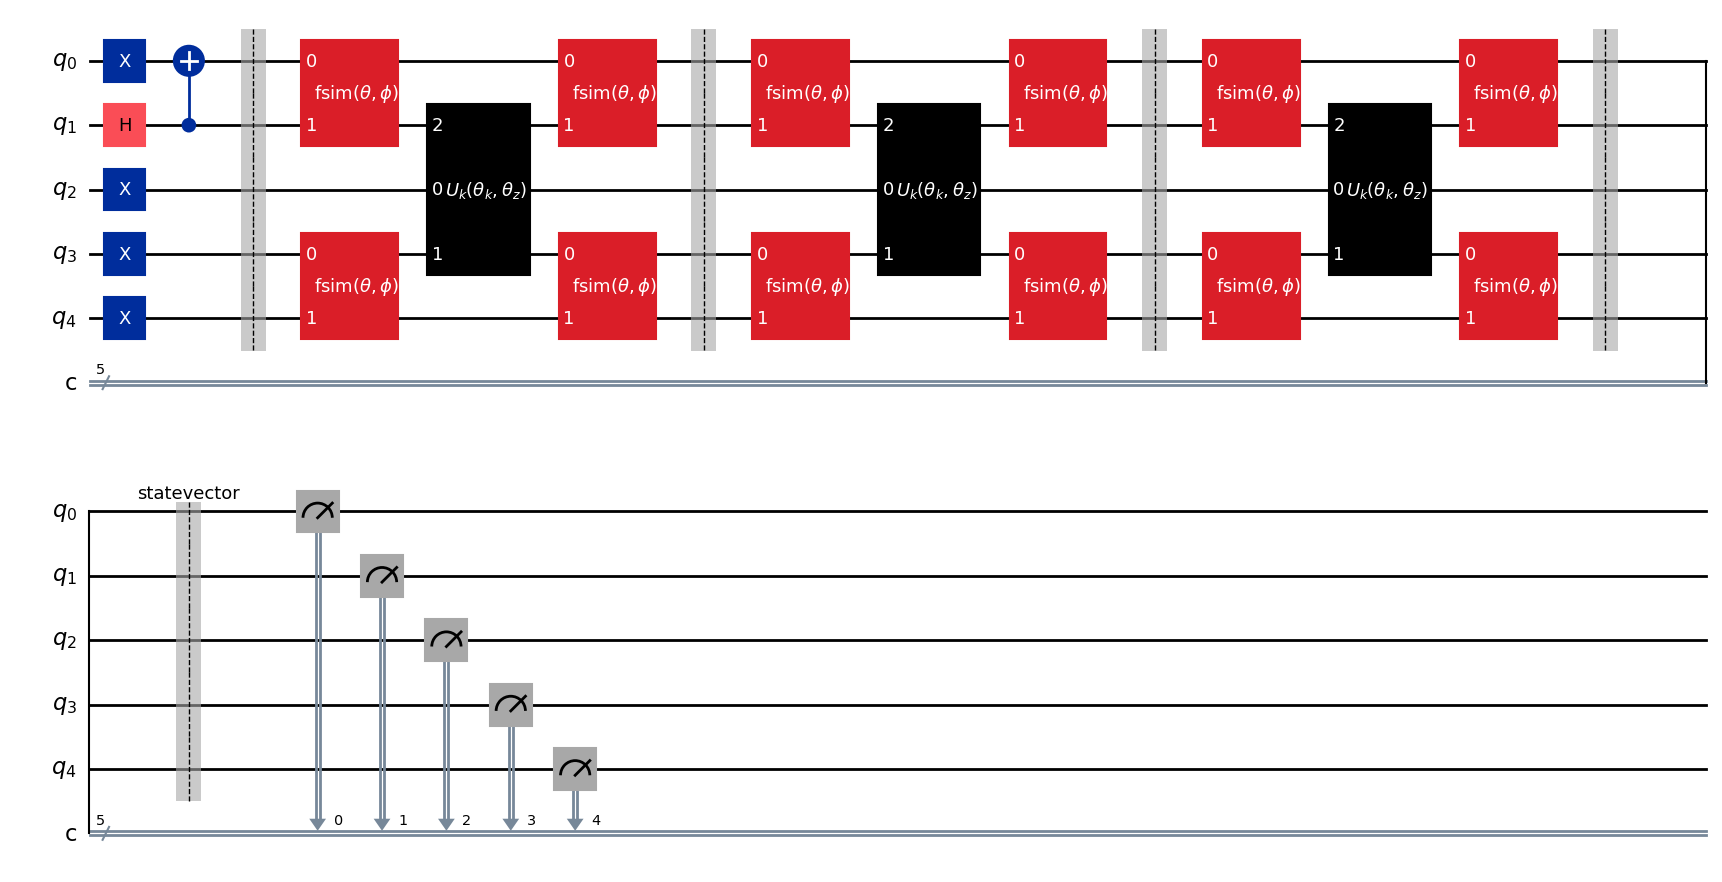

In [67]:
qc_check = qc_list[3]
qc_check.draw(output = 'mpl',style = gate_colours)

In [25]:
estimator = Estimator(approximation=True)
sampler = Sampler()

In [68]:
imp_observables = [SparsePauliOp('I'*N + 'Z' + 'I'*N)]*max_trotter_steps
job_1 = estimator.run(qc_list,imp_observables,shots = None)
expectation_list_1 = list(job_1.result().values)


In [69]:
print(expectation_list_1)

[-1.0000000000000002, -1.0000000000000002, -1.0, -0.9999999999999994, -0.9999999999999991, -0.9999999999999991, -0.9999999999999989, -0.9999999999999989, -0.9999999999999987, -0.9999999999999984, -0.999999999999998, -0.999999999999998, -0.9999999999999981, -0.9999999999999981, -0.9999999999999978, -0.9999999999999977, -0.9999999999999978, -0.9999999999999974, -0.9999999999999972, -0.9999999999999971, -0.9999999999999966, -0.9999999999999964, -0.9999999999999961, -0.999999999999996, -0.9999999999999959, -0.9999999999999958, -0.9999999999999956, -0.9999999999999953, -0.9999999999999953, -0.999999999999995, -0.9999999999999947, -0.9999999999999942, -0.999999999999994, -0.9999999999999939, -0.9999999999999937, -0.9999999999999936, -0.9999999999999934, -0.9999999999999931, -0.9999999999999929, -0.9999999999999927, -0.9999999999999926, -0.9999999999999925, -0.9999999999999922, -0.9999999999999918, -0.9999999999999918, -0.9999999999999916, -0.9999999999999912, -0.999999999999991, -0.999999999

In [89]:
s_fac = 10**6

In [94]:
expectation_list_1_mod = [(i+1)*s_fac for i in expectation_list_1]
print(expectation_list_1_mod)

[-2.220446049250313e-10, -2.220446049250313e-10, 0.0, 5.551115123125783e-10, 8.881784197001252e-10, 8.881784197001252e-10, 1.1102230246251565e-09, 1.1102230246251565e-09, 1.3322676295501878e-09, 1.5543122344752192e-09, 1.9984014443252818e-09, 1.9984014443252818e-09, 1.887379141862766e-09, 1.887379141862766e-09, 2.220446049250313e-09, 2.3314683517128287e-09, 2.220446049250313e-09, 2.55351295663786e-09, 2.7755575615628914e-09, 2.886579864025407e-09, 3.4416913763379853e-09, 3.552713678800501e-09, 3.885780586188048e-09, 3.9968028886505635e-09, 4.107825191113079e-09, 4.218847493575595e-09, 4.440892098500626e-09, 4.6629367034256575e-09, 4.6629367034256575e-09, 4.9960036108132044e-09, 5.329070518200751e-09, 5.773159728050814e-09, 5.995204332975845e-09, 6.106226635438361e-09, 6.328271240363392e-09, 6.439293542825908e-09, 6.550315845288424e-09, 6.8833827526759706e-09, 7.105427357601002e-09, 7.327471962526033e-09, 7.438494264988549e-09, 7.549516567451064e-09, 7.771561172376096e-09, 8.21565038222

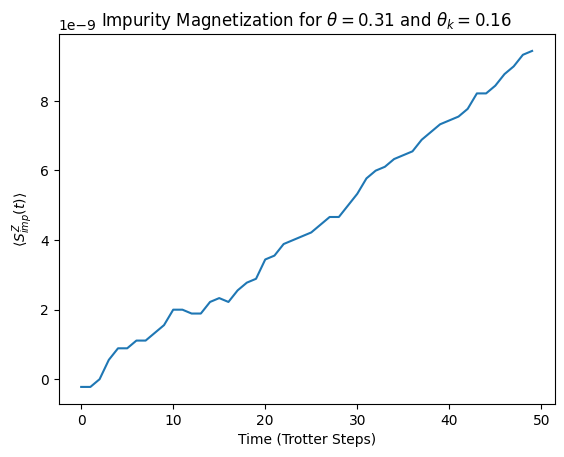

In [96]:
plt.plot(range(max_trotter_steps),expectation_list_1_mod)
plt.title(f'Impurity Magnetization for '+ r'$\theta = $' + f'{round(theta,2)} and ' + r'$\theta_k = $' + f'{round(theta_k,2)}')
plt.xlabel('Time (Trotter Steps)')
plt.ylabel(r'$\langle S^Z_{imp}(t) \rangle$')
plt.show()

## Let's see how the analytical first order results are

In [84]:
e1 = 0.5*(theta_k - np.sqrt(theta_k**2 + 4*theta**2))
e2 = 0.5*(theta_k + np.sqrt(theta_k**2 + 4*theta**2))
w = e2 - e1

a1 = e1/theta
a2 = e2/theta

print(a1,a2)
print(1+a1*a2)
print((a1-a2)**2)

a = (1-a1)*(1-a2)*(1+a1*a2)/((a1-a2)**2)
b = (-((1-a1)**2)*(1+a2**2) - ((1-a2)**2)*(1+a1**2))/(2*(a1-a2)**2)

print(a,b)
print(w)

-0.780776406404415 1.280776406404415
3.3306690738754696e-16
4.249999999999998
-3.9184342045593744e-17 -0.9999999999999998
0.6476559171707594


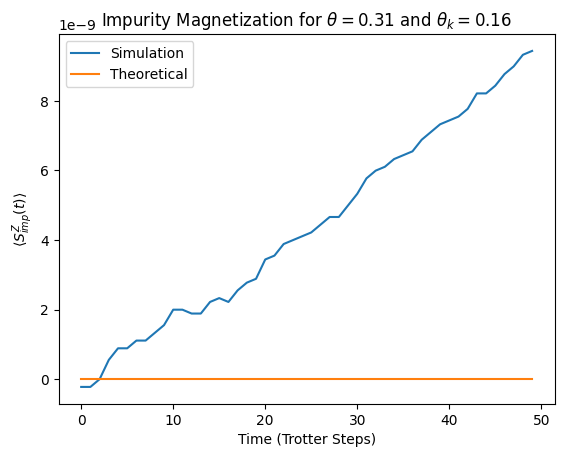

In [98]:
theoretical_expectation = [(b + 0.9999999999999998)*s_fac for t in range(max_trotter_steps)]

plt.plot(range(max_trotter_steps),expectation_list_1_mod,label = 'Simulation')
plt.plot(range(max_trotter_steps),theoretical_expectation,label = 'Theoretical')

plt.title(f'Impurity Magnetization for '+ r'$\theta = $' + f'{round(theta,2)} and ' + r'$\theta_k = $' + f'{round(theta_k,2)}')
plt.xlabel('Time (Trotter Steps)')
plt.ylabel(r'$\langle S^Z_{imp}(t) \rangle$')
plt.legend()
plt.show()

